# Variational Autoencoders

Variational autoencoders view autoencoding from a statistical perspective. Like classical autoencoders, they encode a dataset into a lower dimensional latent space. Additionally, though, variational autoencoders constrain the encoded vectors to roughly follow a probability distribution, e.g. a normal distribution. Here’s an example of a variational autoencoder for the same 1D sequence to sequence monochromatic signal encoding problem.

https://mlgeophysics.github.io/community/projects/auto-encoder/vae/

## Variational Autoencoder¶

Much of this code is from https://blog.keras.io/building-autoencoders-in-keras.html and https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

Tutorials can be found at https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf, https://jaan.io/what-is-variational-autoencoder-vae-tutorial/, and https://arxiv.org/abs/1606.05908

This notebook uses the same toy problem as the autoencoding notebook. Here we demonstrate the use of a variational autoencoder.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats

import tensorflow as tf

#from keras.models import Input 
from keras.models import Model
from keras.models import load_model

from keras.layers import Dense, LeakyReLU, Lambda, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.losses import mse
from keras import backend as K

from sklearn.model_selection import train_test_split

# Init Fidle environment
import fidle


2023-03-21 21:22:13.256974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [4]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
tf.config.run_functions_eagerly(False)

In [6]:
run_id, run_dir, datasets_dir = fidle.init('MNIST1')

<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : MNIST1
Run dir              : ./run/MNIST1
Datasets dir         : /Users/dagoret/MacOSX/Fidle2023/fidle-tp/datasets-fidle
Start time           : 21/03/23 21:22:19
Hostname             : MacBook-Pro-de-admin.local (Darwin)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Save figs            : ./run/MNIST1/figs (False)
tensorflow           : 2.11.0
numpy                : 1.24.2
sklearn              : 1.2.1
matplotlib           : 3.7.1
pandas               : 1.5.3


## generate training, test, and validation data

In [7]:
# generate training, test, and validation data
n = 4096
nt = 128
f = 3.0                  # frequency in Hz
t = np.linspace(0,1,nt)  # time stamps in s
x = np.zeros((n,nt),dtype=np.float32)
phase = np.random.uniform(-np.pi, np.pi, size=n)
for i in range(n):
    x[i,:] = np.sin(2*np.pi*f*t + phase[i] )

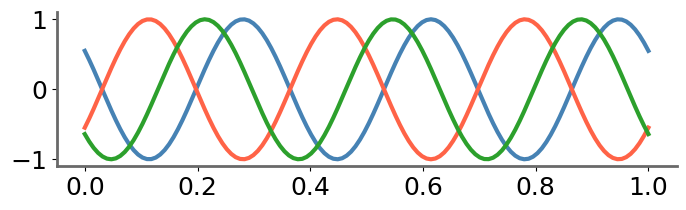

In [8]:
# QC generated data is phase shifted but one frequency
plt.figure(figsize=(8,2))
for i in range(3):
    plt.plot(t,x[np.random.randint(0,nt-1), :])
plt.show()

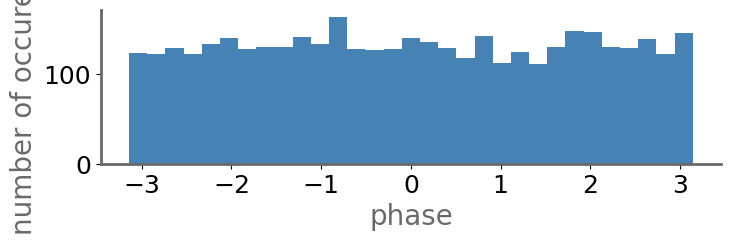

In [9]:
# QC generated phase in [-pi,pi]
plt.figure(figsize=(8,2))
plt.hist(phase,bins=31)
plt.xlabel('phase')
plt.ylabel('number of occurence')
plt.show()

In [10]:
# split into test, validation, and training sets
x_temp, x_test, _, _ = train_test_split(x, x, test_size=0.05)
x_train, x_valid, _, _ = train_test_split(x_temp,
                                          x_temp,
                                          test_size=0.1)
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

In [11]:
# specify training parameters and callback functions

# batch size for stochastic solver  
batch_size = 16

# number of times entire dataset is considered in stochastic solver
epochs = 100

# unique name for the network for saving
unique_name = "testvae"
model_filename = 'aen_sin_%03dHz_n=%05d_'%(int(f),nt)+unique_name+'.h5'

# training history file name
history_filename = 'results_'+unique_name+'.npz'

# stop early after no improvement past epochs=patience and be verbose
earlystopper = EarlyStopping(patience=100, verbose=1)

# checkpoint and save model when improvement occurs 
checkpointer = ModelCheckpoint(model_filename, verbose=1, save_best_only=True)

# consolidate callback functions for convenience 
callbacks = [earlystopper, checkpointer]

Now things get a bit different from a vanilla autoencoder. First, we set the dimensions of the latent space. For this example we can get away with only one dimension. Intuitively, since the only difference between training examples is the phase, we only need one to encode one dimension.

In [12]:
# encoding dimension; i.e. dimensionality of the latent space
encoding_dim=1

Next we define a function to draw samples from a Gaussian, given the mean and standard deviation. We sample to encode in the latent space. Further, the way this function is defined, it lets us use backpropagation on the mean and standard deviation, even though there's a probabilistic element to this operation (this is the "reparameterization trick").

In [13]:
# define a function to sample from gaussian, given mean and log variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(encoding_dim,))
    return z_mean + K.exp(z_log_sigma) * epsilon

Network structure is similar to the autoencoder. The main difference is in the middle of the network: z_mean and z_log_sigma. These layers encode a mean and log(std) that determine the pdf that we draw the encoding in the latent space from. 



The "Lambda" layer then draws a sample from that pdf, and z is the encoded signal in the latent space.

## input layer is full time series of length nt

In [14]:
# input layer is full time series of length nt
inputs = Input((nt,))

## encoder hidden layers

In [15]:
# encoder hidden layers
encoded = Dense(64)(inputs) 
encoded = LeakyReLU(alpha=0.2)(encoded)
encoded = Dense(32)(encoded)
encoded = LeakyReLU(alpha=0.2)(encoded)
z_mean = Dense(encoding_dim)(encoded)
z_log_sigma = Dense(encoding_dim)(encoded)
z = Lambda(sampling,output_shape=(encoding_dim,))([z_mean,z_log_sigma])

## decoder hidden layers

In [16]:
decoded = Dense(32)(z)
decoded = LeakyReLU(alpha=0.2)(decoded)
decoded = Dense(64)(decoded)
decoded = LeakyReLU(alpha=0.2)(decoded)
# output layer is same length as input
outputs = Dense(nt,activation='tanh')(decoded)

## consolidate to define autoencoder model inputs and outputs

In [17]:
# consolidate to define autoencoder model inputs and outputs
vae = Model(inputs=inputs, outputs=outputs)

In [18]:
# specify encoder and decoder model for easy encoding and decoding later
encoder = Model(inputs=inputs, outputs=[z_mean,z_log_sigma,z],name='encoder')
# create a placeholder for an encoded input
encoded_input = Input(shape=(encoding_dim,))

In [19]:
# retrieve the last layers of the autoencoder model
decoded_output = vae.layers[-5](encoded_input)
decoded_output = vae.layers[-4](decoded_output)
decoded_output = vae.layers[-3](decoded_output)
decoded_output = vae.layers[-2](decoded_output)
decoded_output = vae.layers[-1](decoded_output)
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoded_output, name='decoder')

In [20]:
print('Full autoencoder')
print(vae.summary())

Full autoencoder
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['leaky_re_lu[0][0]']            
                                                                             

## VAE loss

The loss function is another key difference between standard autoencoders and variational autoencoders. A standard autoencoder simply minimizes reconstruction loss. 

- A variational autoencoder minimizes both reconstruction loss and the KL divergence. 

- The KL divergence is a measure of how much two probability distributions differ. 


Minimizing the KL divergence here means that we are encouraging the latent space encodings to have a normal distribution. The regularization parameter balances between reconstruction loss and enforcing a normal distribution in the latent space.

In [21]:
# specify loss
# regularization balances signal reconstruction with
# a Gaussian distribution in the latent space 
regularization = 10
def vae_loss(input_img, output):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(output-input_img))
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
    # return the average loss over all images in batch
    total_loss = K.mean(reconstruction_loss + regularization*kl_loss)    
    return total_loss

vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse'],experimental_run_tf_function=False,run_eagerly=False)
vae.run_eagerly = False

## train variational autoencoder

In [22]:
# train variational autoencoder
results = vae.fit(x_train,x_train,
                      shuffle=True,
                      batch_size = batch_size, 
                      epochs = epochs,
                      validation_data = (x_valid,x_valid),
                      callbacks = callbacks)

Train on 3501 samples, validate on 390 samples
Epoch 1/100


2023-03-21 21:22:20.856452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 21:22:20.886582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-21 21:22:20.941173: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense_5/bias/v/Assign' id:578 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/v, training/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future.

3488/3501 [============================>.] - ETA: 0s - loss: 583.3160 - mean_squared_error: 0.2747
Epoch 1: val_loss improved from inf to 478.08443, saving model to aen_sin_003Hz_n=00128_testvae.h5


/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-03-21 21:22:21.478424: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:235 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_6_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3501/3501 [==============================] - 1s 193us/sample - loss: 582.6102 - mean_squared_error: 0.2746 - val_loss: 478.0844 - val_mean_squared_error: 0.2300
Epoch 2/100
3344/3501 [===========================>..] - ETA: 0s - loss: 358.6389 - mean_squared_error: 0.1658
Epoch 2: val_loss improved from 478.08443 to 165.48518, saving model to aen_sin_003Hz_n=00128_testvae.h5
3501/3501 [==============================] - 0s 92us/sample - loss: 351.8859 - mean_squared_error: 0.1628 - val_loss: 165.4852 - val_mean_squared_error: 0.0747
Epoch 3/100
3424/3501 [============================>.] - ETA: 0s - loss: 152.6329 - mean_squared_error: 0.0647
Epoch 3: val_loss improved from 165.48518 to 124.36718, saving model to aen_sin_003Hz_n=00128_testvae.h5
3501/3501 [==============================] - 0s 90us/sample - loss: 151.3344 - mean_squared_error: 0.0641 - val_loss: 124.3672 - val_mean_squared_error: 0.0516
Epoch 4/100
3424/3501 [============================>.] - ETA: 0s - loss: 124.9619 - mea

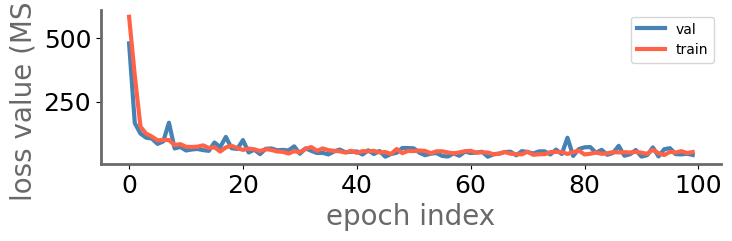

In [23]:
# QC training and validation curves (should follow eachother)
plt.figure(figsize=(8,2))
plt.plot(results.history['val_loss'], label='val')
plt.plot(results.history['loss'], label='train')
plt.xlabel('epoch index')
plt.ylabel('loss value (MSE)')
plt.legend()
plt.show()

## First, let's check to see how well the encoder is working.

In [24]:
encoded_test = np.array(encoder.predict(x_test))
vae_test = vae.predict(x_test)

/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-03-21 21:22:55.786788: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/BiasAdd' id:64 op device:{requested: '', assigned: ''} def:{{{node dense_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2/MatMul, dense_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-03-21 21:22:56.048307: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_6/Tanh' id:156 op device:{requested: '', assigned: ''} def:{{{node dense_6/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_co

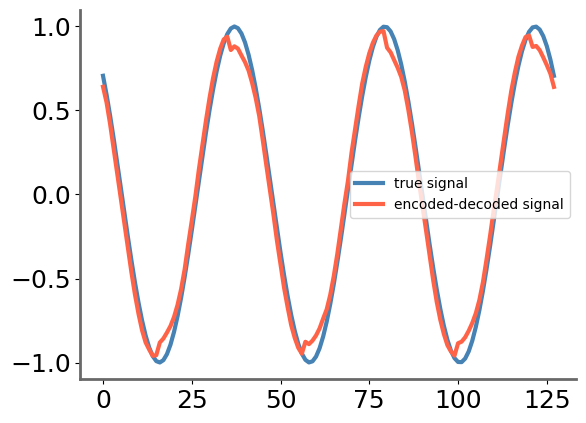

In [25]:
plt.plot(x_test[0],label='true signal')
plt.plot(vae_test[0],label='encoded-decoded signal')
plt.legend()
plt.show()

## Now let's look at the distribution of samples in the latent space, to see how gaussian it is.

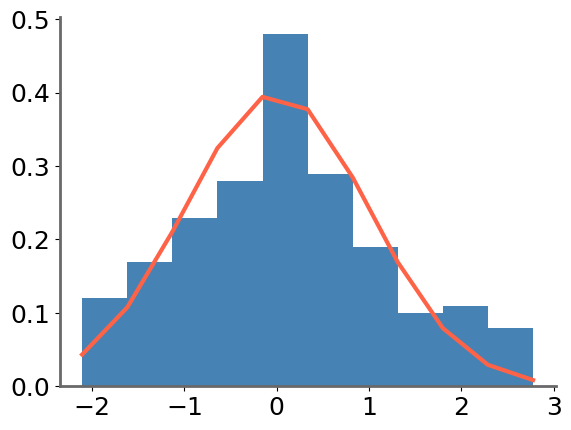

In [26]:
import matplotlib.mlab as mlab
n,bins,patches=plt.hist(encoded_test[2,:,:].flatten(),bins=10,density=True)
plt.plot(bins,scipy.stats.norm.pdf(bins,0,1))
plt.show()

## Now let's see how the decoded signal depends on the latent vector.

2023-03-21 21:22:56.504521: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_6_1/Tanh' id:172 op device:{requested: '', assigned: ''} def:{{{node dense_6_1/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


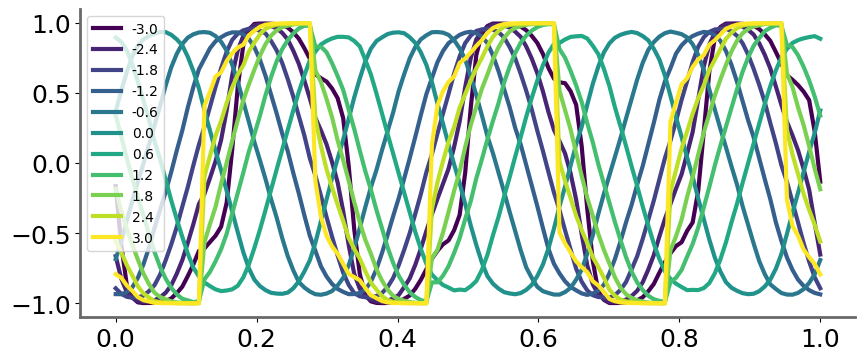

In [27]:
from matplotlib.pylab import cm
plt.figure(figsize=(10,4))
latent_inputs = np.repeat(np.linspace(-3,3,11)[:,np.newaxis],encoding_dim,axis=1)
decoded_latent_inputs = decoder.predict(latent_inputs)
colors = cm.viridis(np.linspace(0,1,len(latent_inputs)))
for i,latent_input in enumerate(decoded_latent_inputs):
    plt.plot(t,latent_input,color=colors[i])
labels = ["{0:.1f}".format(l) for l in latent_inputs[:,0]]
plt.legend(labels)
plt.show()

Interestingly, the autoencoder has learned to use the latent vector (value in this case, since we specified an encoding dimension of 1) as a proxy for phase. As the latent value changes, the phase of the decoded signal changes. Latent values near zero reproduce a sine wave well, while values far from zero produce signals that aren't exactly sinusoidal.